### Volatility Modeling on Exchange rate returns

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [135]:
from scipy.stats import norm
from datetime import datetime, timedelta

In [21]:
# import FX rates

# import data
# let's import few top  traded currency pairs

start_date=pd.to_datetime('2000-01-01')
end_date=pd.to_datetime("2022-01-30") 


from pandas_datareader import data
curr_pair= "DEXUSUK"
fx = data.DataReader(curr_pair, 'fred',start=start_date)

print('NULL: ',fx.isna().sum())

NULL:  DEXUSUK    226
dtype: int64


In [22]:
fx=fx.fillna(method='ffill')
print('NULL: ',fx.isna().sum())

NULL:  DEXUSUK    0
dtype: int64


<AxesSubplot:xlabel='DATE'>

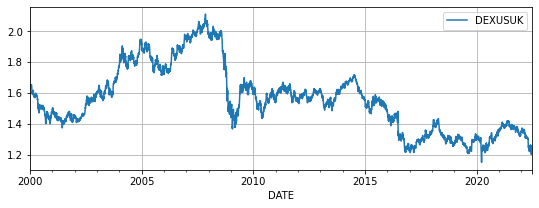

In [23]:
fx.plot(grid=True,figsize=(9,3))

array([[<AxesSubplot:title={'center':'DEXUSUK'}>]], dtype=object)

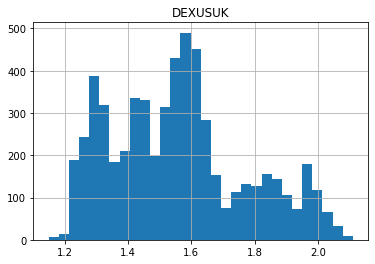

In [24]:
fx.hist(bins=30)

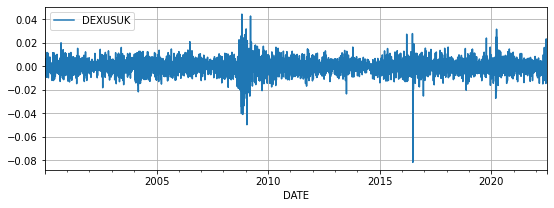

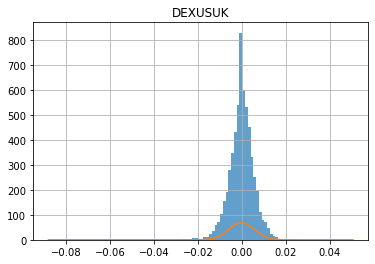

In [69]:
# log return
fx_ret=np.log(fx).diff().dropna()

fx_ret.plot(grid=True,figsize=(9,3))
fx_ret.hist(bins=100,alpha=0.7)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
y = norm.pdf(x, fx_ret.mean(), fx_ret.std())
plt.plot(x, y)
plt.show()


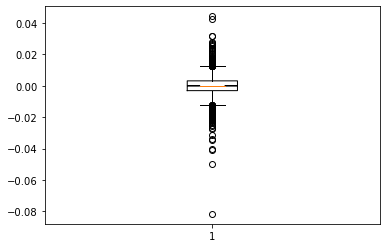

In [42]:
plt.boxplot(fx_ret,meanline=True,notch=True)
plt.show()

C:\Users\prano\anaconda3\envs\finance\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


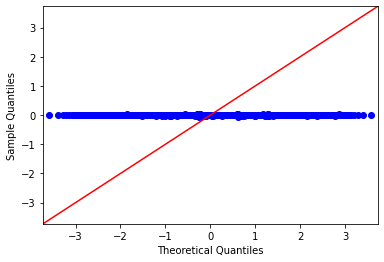

In [71]:
import pylab as py

sm.qqplot(np.sort(fx_ret),  line = "45", fit = False)
py.show()

These plots show how the log returns differ from normal distribution. It has extremely heavy tails, most of the distribution is just at the 0th quantile.

#### Stationarity

In [74]:
# stationarity ADF test
from statsmodels.tsa.stattools import adfuller as adf

ad=adf(fx_ret)
ad # second number is the p-value, low means stationary

(-24.989235214944223,
 0.0,
 10,
 5858,
 {'1%': -3.4314667920446977,
  '5%': -2.862033517230979,
  '10%': -2.5670326970835085},
 -43496.47764574379)

#### ACF, PACF

In [76]:
from statsmodels.graphics.tsaplots import plot_acf # gives q, MA
from statsmodels.graphics.tsaplots import plot_pacf # gives p, AR

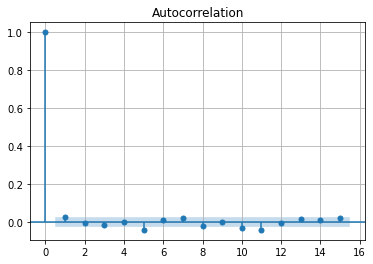

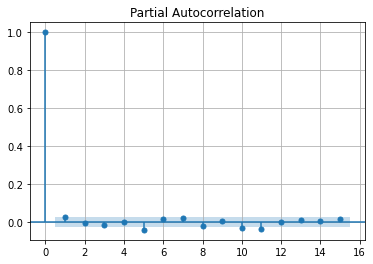

In [84]:
plot_acf(fx_ret,lags=15,alpha=0.05) # inside the band then not relevant
plt.grid()
plot_pacf(fx_ret,lags=15,alpha=0.05) # inside the band then not relevant
plt.grid()
plt.show()

**Inference**

fx_ret- is stationary, has barely significant ACF and PACF at lags 5 and 11.

### Let's fit ARIMA(4,0,4) and look at residuals

We choose $(p,q)$ values based on ACF and PACF. Can also use grid-search over AIC/BCI criteria.

In [99]:
from statsmodels.tsa.arima.model import ARIMA

model=ARIMA(fx_ret,order=(4,0,4))
model_fit=model.fit()
model_fit.summary()

C:\Users\prano\anaconda3\envs\finance\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  warnings.warn('No frequency information was'
C:\Users\prano\anaconda3\envs\finance\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  warnings.warn('No frequency information was'
C:\Users\prano\anaconda3\envs\finance\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                DEXUSUK   No. Observations:                 5869
Model:                 ARIMA(4, 0, 4)   Log Likelihood               21888.055
Date:                Sat, 09 Jul 2022   AIC                         -43756.110
Time:                        14:07:05   BIC                         -43689.336
Sample:                    01-04-2000   HQIC                        -43732.895
                         - 07-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -5.268e-05   7.81e-05     -0.674      0.500      -0.000       0.000
ar.L1         -0.0214      0.131     -0.164      0.870      -0.278       0.235
ar.L2         -0.1675      0.115     -1.454      0.146      -0.393       0.058
ar.L3          0.1093      0.108      1.009      0.313      -0.103       0.321
ar.L4         -0.7661      0.110     -6.956      0.000      -0.982      -0.550
ma.L1          0.0506      0.134      0.377      0.706      -0.212       0.314
ma.L2          0.1621      0.121      1.338      0.181      -0.075       0.399
ma.L3         -0.1217      0.113     -1.074      0.283      -0.344       0.100
ma.L4          0.7646      0.115      6.629      0.000       0.539       0.991
sigma2      3.374e-05   2.61e-07    129.192      0.000    3.32e-05    3.43e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             30070.11
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.36   Skew:                            -0.66
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

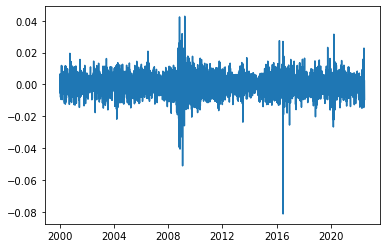

In [91]:
residuals = pd.DataFrame(model_fit.resid)
plt.plot(residuals)

In [ ]:
# we can do further tests of heteroskedasticity on residuals
    # from statsmodels.stats.diagnostic import het_breuschpagan

**Residual is Heteroskedastic**

Based on the folowing-
1. p-value Heteroskedasticity
2. the residual plot (for homoskedastic- should have looked like a band)

#### Non linear dependence

**Non-linear time dependence in the time series is
exhibited with the time dependence of the squared series.**

In [86]:
# stationarity
ad_s=adf(fx_ret**2)
ad_s # second number is the p-value, low means stationary

(-9.773687902697842,
 7.026210888821792e-17,
 26,
 5842,
 {'1%': -3.431469852046985,
  '5%': -2.86203486921003,
  '10%': -2.5670334167799527},
 -88884.10528737206)

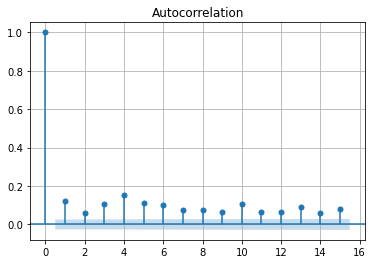

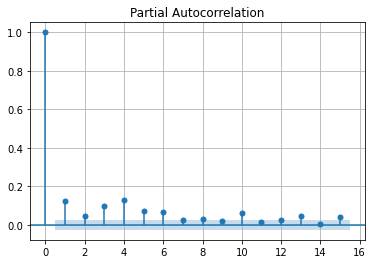

In [85]:
# acf and pacf on squared log returns
plot_acf(fx_ret**2,lags=15,alpha=0.05) # inside the band then not relevant
plt.grid()
plot_pacf(fx_ret**2,lags=15,alpha=0.05) # inside the band then not relevant
plt.grid()
plt.show()

We see that squared log returns are stationary, and, have more significant ACF PACF values. Suggests towards non-linear time dependence. Use GARCH.

### GARCH 

Since Heteroskedasticity and non-linear dependence hence it is better to use GARCH. 

From PACF of squared series we can guess the (p,q) values.

In [101]:
from arch import arch_model

documentation for the package https://arch.readthedocs.io/en/latest/univariate/forecasting.html

In [229]:
# fitting garch(6,0)=arch(6)
model = arch_model(100*fx_ret.DEXUSUK, p=6, q=0,vol='GARCH', dist='normal') # studentt another option (good for heavy tails)
model_fit = model.fit()
model_fit.summary()

Iteration:      1,   Func. Count:     10,   Neg. LLF: 49947.89773044091
Iteration:      2,   Func. Count:     24,   Neg. LLF: 9596.45964654937
Iteration:      3,   Func. Count:     37,   Neg. LLF: 17161327.700853273
Iteration:      4,   Func. Count:     47,   Neg. LLF: 8725411.65714664
Iteration:      5,   Func. Count:     57,   Neg. LLF: 157020.63096631225
Iteration:      6,   Func. Count:     67,   Neg. LLF: 175990.16339841404
Iteration:      7,   Func. Count:     77,   Neg. LLF: 1163102.237765539
Iteration:      8,   Func. Count:     88,   Neg. LLF: 7903.660371753669
Iteration:      9,   Func. Count:    100,   Neg. LLF: 18724.04288844845
Iteration:     10,   Func. Count:    111,   Neg. LLF: 4934.789104561931
Iteration:     11,   Func. Count:    122,   Neg. LLF: 4733.013711186044
Iteration:     12,   Func. Count:    132,   Neg. LLF: 4733.666284083074
Iteration:     13,   Func. Count:    143,   Neg. LLF: 4721.288386288086
Iteration:     14,   Func. Count:    153,   Neg. LLF: 4685.8958

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                DEXUSUK   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -4685.89
Distribution:                  Normal   AIC:                           9387.77
Method:            Maximum Likelihood   BIC:                           9441.19
                                        No. Observations:                 5869
Date:                Sun, Jul 10 2022   Df Residuals:                     5868
Time:                        10:48:41   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         2.3019e-03  6.704e-03      0.343      0.731 [-1.084e-02,1.544e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.1516  9.000e-03     16.847  1.107e-63     [  0.134,  0.169]
alpha[1]       0.0367  1.395e-02      2.635  8.414e-03 [9.414e-03,6.408e-02]
alpha[2]       0.0832  1.924e-02      4.323  1.541e-05   [4.547e-02,  0.121]
alpha[3]       0.0553  1.604e-02      3.448  5.641e-04 [2.387e-02,8.674e-02]
alpha[4]       0.1319  3.356e-02      3.931  8.476e-05   [6.613e-02,  0.198]
alpha[5]       0.1202  2.201e-02      5.462  4.720e-08   [7.707e-02,  0.163]
alpha[6]       0.1040  2.300e-02      4.521  6.146e-06   [5.891e-02,  0.149]
============================================================================

Covariance estimator: robust
"""

In [214]:
# making prediction
pred = model_fit.forecast(horizon=1)
type(pred) # pred has 4 attributes, mean, variance, residual_variance, simulations

C:\Users\prano\anaconda3\envs\finance\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


arch.univariate.base.ARCHModelForecast

In [215]:
pred.variance.values[-1,:][0]

0.5606380347721326

In [216]:
pred.residual_variance.values[-1,:][0]

0.5606380347721326

In [250]:
# predicting volatility

rolling_predictions = [] # std or vol or sqrt(var)
pred_mean=[]
test_size = 365

for i in range(test_size):
    train = 100*fx_ret[:-(test_size-i)] # note: multiplied by 100
    model = arch_model(train, p=6, q=0)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    pred_mean.append(pred.mean.values[-1,:][0]/100) # note: divided by 100
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0])/100) # note: divided by 100

C:\Users\prano\anaconda3\envs\finance\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\prano\anaconda3\envs\finance\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\prano\anaconda3\envs\finance\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex

In [251]:
# make dataframe
rolling_predictions = pd.Series(rolling_predictions, index=fx_ret.index[-365:])

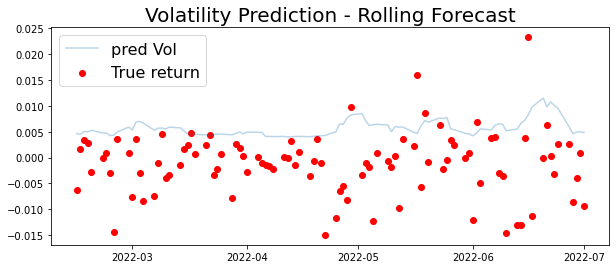

In [252]:
plt.figure(figsize=(10,4))
true = plt.scatter(fx_ret.index[-100:],fx_ret[-100:],color='red',label='True return')
preds, = plt.plot(rolling_predictions[-100:],alpha=0.3,label='pred Vol') # divided by 100, to compensate y*100
plt.title('Volatility Prediction - Rolling Forecast', fontsize=20)
plt.legend( fontsize=16)

**NOTE:**
We have divided $\sqrt{var}$ by $100$ as we put in the return-data*100 during model.fit. This was done for gradient convergence of arch_model (as it fails on very low values of y).

In [253]:
# getting future prediction of volatility
horizon=4 #number of days
pred = model_fit.forecast(horizon=horizon)
future_dates = [fx_ret.index[-1] + timedelta(days=i) for i in range(1,horizon+1)]
pred = pd.Series(np.sqrt(pred.variance.values[-1,:])/100, index=future_dates)

C:\Users\prano\anaconda3\envs\finance\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Text(0.5, 1.0, 'Volatility Prediction - Next 4 Days')

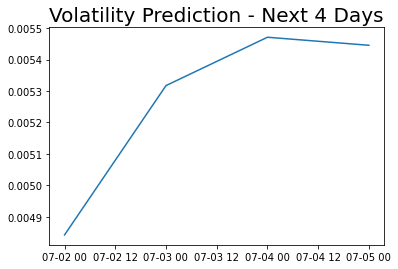

In [254]:
plt.figure()
plt.plot(pred)
plt.title('Volatility Prediction - Next 4 Days', fontsize=20)

### VaR 

To be done. For Ref: https://rpubs.com/ionaskel/VaR_Garch_market_risk and https://arch.readthedocs.io/en/latest/univariate/univariate_volatility_forecasting.html#Value-at-Risk-Forecasting

In [255]:
# quantile

var_q=np.quantile(fx_ret,0.05)
var_index=fx_ret.DEXUSUK<var_q
var_q

-0.009273090824800911

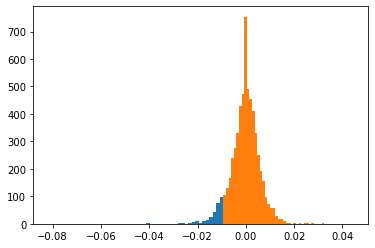

In [256]:
bins=50
plt.hist(fx_ret[var_index],bins=bins)
plt.hist(fx_ret[~var_index],bins=bins)
plt.show()

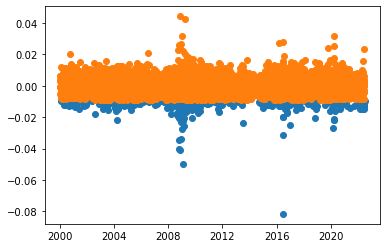

In [257]:
plt.scatter(fx_ret.index[var_index],fx_ret[var_index])
plt.scatter(fx_ret.index[~var_index],fx_ret[~var_index])

**VaR:** $\mu +\sigma q_0.05$ where $q_0.05$ is the 0.05 quantile of normal distribution. 

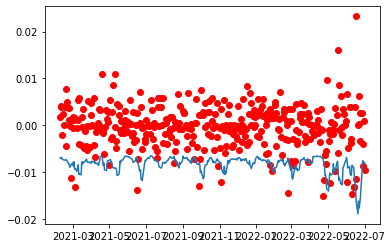

In [263]:
var=pred_mean+ rolling_predictions* norm.ppf(0.05)
plt.plot(var)
plt.scatter(fx_ret.index[-365:],fx_ret[-365:],color='red',label='True return')

In [166]:
# using dist='t' in GARCH is better for VaR